In [31]:
from typing import Tuple

import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from sklearn.metrics import (
    auc,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
)

In [32]:
pio.renderers.default = "png"

In [33]:
actionclip_variation = "vit-b-16-16f"

In [34]:
y = np.load('y.npy', allow_pickle=True)
y_true = np.load('y_true.npy', allow_pickle=True)

In [35]:
def make_roc_plot(y_true: np.ndarray, y_score: np.ndarray) -> Tuple[go.Figure, float]:
    """
    Plot the ROC curve.

    Args:
        y_true: The true labels.
        y_score: The predicted scores.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    fig = go.Figure()
    fig.add_scatter(
        x=fpr,
        y=tpr,
        mode="lines",
        line=dict(color="darkorange", width=2),
        hovertext=thresholds,
        showlegend=False,
    )
    fig.add_scatter(
        x=[0, 1],
        y=[0, 1],
        mode="lines",
        line=dict(color="navy", width=2, dash="dash"),
        showlegend=False,
    )
    fig.update_layout(
        title=f"{actionclip_variation} ROC - AUC: {roc_auc:.3f}",
        xaxis_title="False Positive Rate",
        yaxis_title="True Positive Rate",
    )

    return fig, roc_auc


def make_pr_plot(y_true: np.ndarray, y_score: np.ndarray) -> Tuple[go.Figure, float]:
    """
    Plot the PR curve.

    Args:
        y_true: The true labels.
        y_score: The predicted scores.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    pr_auc = auc(recall, precision)

    fig = go.Figure()
    fig.add_scatter(
        x=recall,
        y=precision,
        mode="lines",
        hovertext=thresholds,
        line=dict(color="#636efa"),
        fill="tozeroy",
        showlegend=False,
    )
    fig.add_scatter(
        x=[0, 1],
        y=[1, 0],
        mode="lines",
        line=dict(color="navy", width=2, dash="dash"),
        showlegend=False,
    )
    fig.update_layout(
        title=f"{actionclip_variation} Precision-Recall Curve - AUC: {pr_auc:.3f}",
        xaxis_title="False Positive Rate",
        yaxis_title="True Positive Rate",
    )

    return fig, pr_auc


def make_confusion_matrix_plot_fn_equals_0(
    y_true: np.ndarray, y_score: np.ndarray
) -> Tuple[go.Figure, Tuple[float, float, float, float]]:
    """
    Plot the confusion matrix for the threshold where FN = 0.

    Returns:
        The confusion matrix plot and
        the confusion matrix values in the form of: TP, FN, FP, TN (reading the matrix from left to right and top to bottom).
    """
    # get the threshold where FN = 0
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    fn_equals_0_threshold = thresholds[
        np.argmax(tpr)
    ]  # argmax will return the first occurrence of the max value (1, as TP/(TP + FN = 0) = TP/TP = 1)

    # get the confusion matrix
    y_pred = y_score >= fn_equals_0_threshold
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()

    X_LABELS = ["Positive (Alarm)", "Negative"]
    Y_LABELS = ["Negative", "Positive (Alarm)"]

    Z = [[FP, TN], [TP, FN]]

    # plot the confusion matrix
    fig = go.Figure(
        data=go.Heatmap(
            z=Z, x=X_LABELS, y=Y_LABELS, colorscale="viridis", texttemplate="%{z}"
        )
    )
    fig.update_layout(
        title=f"Confusion Matrix for threshold {fn_equals_0_threshold:.3f} (FN = 0, {actionclip_variation})",
        xaxis_title="Predicted value",
        yaxis_title="Real value",
    )

    return fig, (TP, FN, FP, TN)

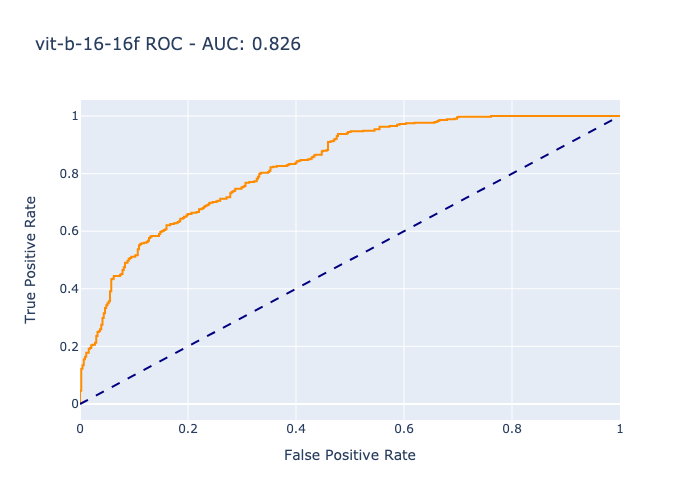

In [36]:
fig, roc_auc = make_roc_plot(y_true, y)
fig.show()

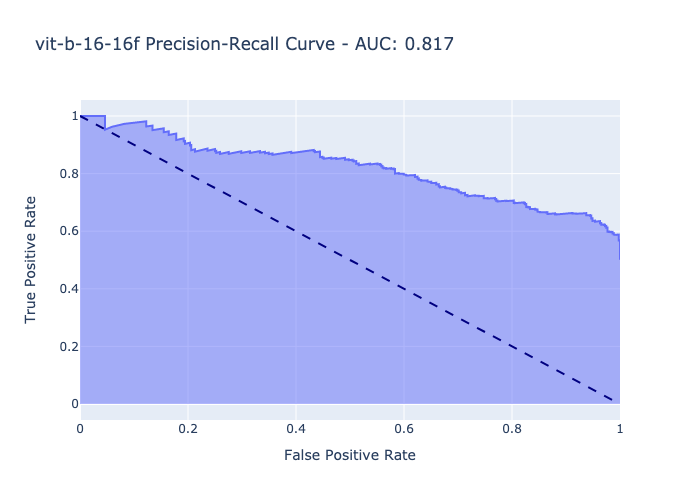

In [37]:
fig, pr_auc = make_pr_plot(y_true, y)
fig.show()

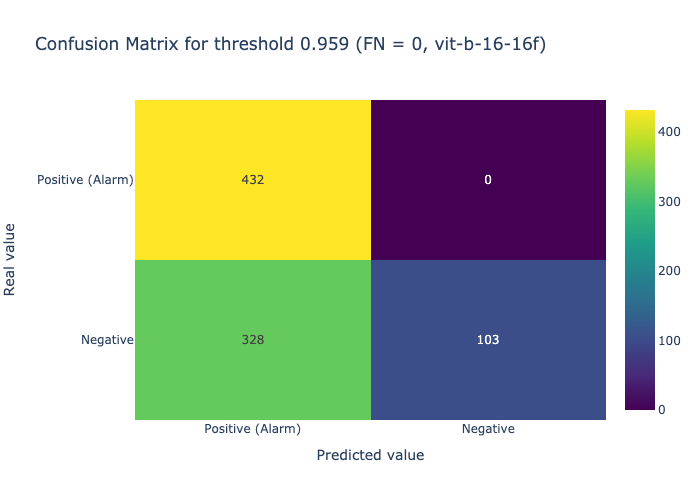

In [38]:
fig, (TP, FN, FP, TN) = make_confusion_matrix_plot_fn_equals_0(y_true, y)
fig.show()